In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler

In [22]:
# DATA_ROOT = "../input/"
data_path = 'data/'
dfoff = pd.read_csv(os.path.join(data_path,'train_offline.csv'))
dftest = pd.read_csv(os.path.join(data_path,'test_offline.csv'))
dftest = dftest[~dftest.Coupon_id.isna()]
dftest.reset_index(drop=True, inplace=True)
print(dfoff.shape)
print(dftest.shape)
dfoff.head()
# 會員ID 商品ID 優惠券ID 優惠券折價 用戶經常活動地點離商家最近距離  優惠券取得時間 購買商品時間 

(1160742, 7)
(306313, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN


In [23]:
def label(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d')-pd.to_datetime(row['Date_received'], format='%Y%m%d') 
        if td <= pd.Timedelta(15,'D'):
            return 1
    return 0

dfoff['label'] = dfoff.apply(label , axis=1)
print(dfoff["label"].value_counts())
dfoff.head()

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0


In [24]:
# dfoff['Date'] = pd.to_datetime(dfoff['Date'], format='%Y%m%d') 
# dfoff['Date_received'] = pd.to_datetime(dfoff['Date_received'], format='%Y%m%d')

dfoff.User_id = dfoff.User_id.astype('object')
dfoff.Merchant_id = dfoff.Merchant_id.astype('object')
dfoff.Coupon_id = dfoff.Coupon_id.astype('object')

dfoff.Distance.value_counts()

0.0     501931
10.0    166877
1.0     143551
2.0      82186
3.0      54214
4.0      39495
5.0      30317
6.0      23976
7.0      19029
8.0      15982
9.0      13358
Name: Distance, dtype: int64

In [25]:
def getWeekday(row):
    if (np.isnan(row)) or (row==-1):
        return row
    else:
        return pd.to_datetime(row, format = "%Y%m%d").dayofweek+1 # add one to make it from 0~6 -> 1~7

dfoff['weekday'] = dfoff['Date_received'].apply(getWeekday)
dftest['weekday'] = dftest['Date_received'].apply(getWeekday)

In [26]:
# weekday_type (weekend = 1)
dfoff['weekday_type'] = dfoff['weekday'].astype('str').apply(lambda x : 1 if x in [6,7] else 0 ) # apply to trainset
dftest['weekday_type'] = dftest['weekday'].astype('str').apply(lambda x : 1 if x in [6,7] else 0 ) # apply to testset

In [27]:
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [28]:
# Generate features - coupon discount and distance
def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):
    
    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].astype('str').apply(convertRate)
    df['discount_man'] = df['Discount_rate'].astype('str').apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].astype('str').apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].astype('str').apply(getDiscountType)
    
    # convert distance
    df.loc[df.Distance.isna(), "Distance"] = 99
    return df

dfoff = processData(dfoff)
dftest = processData(dftest)

In [29]:
## Naive model
def split_train_valid(row, date_cut="20160416"):
    is_train = True if pd.to_datetime(row, format="%Y%m%d") < pd.to_datetime(date_cut, format="%Y%m%d") else False
    return is_train
    
df = dfoff[dfoff['label'] != -1].copy()
df["is_train"] = df["Date_received"].apply(split_train_valid)
train = df[df["is_train"]]
valid = df[~df["is_train"]]
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
print("Train size: {}, #positive: {}".format(len(train), train["label"].sum()))
print("Valid size: {}, #positive: {}".format(len(valid), valid["label"].sum()))

Train size: 667753, #positive: 32472
Valid size: 79216, #positive: 3832


In [30]:
original_feature = ['discount_rate',
                    'discount_type',
                    'discount_man', 
                    'discount_jian',
                    'Distance', 
                    'weekday', 
                    'weekday_type'] + weekdaycols
print(len(original_feature),original_feature)

14 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [31]:
predictors = original_feature
print(predictors)

def check_model(data, predictors):
    
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        max_iter=100, 
        shuffle=True, 
        n_jobs=1,
        class_weight=None)

    model = Pipeline(steps=[
        ('ss', StandardScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__alpha': [ 0.001, 0.01, 0.1],
        'en__l1_ratio': [ 0.001, 0.01, 0.1]
    }

    folder = StratifiedKFold(n_splits=3, shuffle=True)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(data[predictors], 
                                  data['label'])
    
    return grid_search

['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [32]:
model = check_model(train, predictors)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.3min finished
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning

In [34]:
y_valid_pred = model.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [35]:
from sklearn.metrics import roc_auc_score, accuracy_score
auc_score = roc_auc_score(y_true=valid.label, y_score=y_valid_pred[:,1])
acc = accuracy_score(y_true=valid.label, y_pred=y_valid_pred.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

Validation AUC: 0.743, Accuracy: 0.952


In [36]:
targetset = dftest.copy()
print(targetset.shape)
targetset = targetset[~targetset.Coupon_id.isna()]
targetset.reset_index(drop=True, inplace=True)
testset = targetset[predictors].copy()

y_test_pred = model.predict_proba(testset[predictors])
test1 = testset.copy()
test1['pred_prob'] = y_test_pred[:, 1]
print(test1.shape)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


(306313, 19)
(306313, 15)


In [37]:
output = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], test1["pred_prob"]), axis=1)
print(output.shape)

output.loc[:, "User_id"] = output["User_id"].apply(lambda x:str(int(x)))
output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x:str(int(x)))
output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x:str(int(x)))
output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
output.reset_index(drop=True, inplace=True)


(306313, 4)


In [38]:
### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN NAME: uid, label
out = output.groupby("uid", as_index=False).mean()
out = out[["uid", "pred_prob"]]
out.columns = ["uid", "label"]
out.head()

,uid,label
0,1000020_2705_20160519,0.114013
1,1000020_8192_20160513,0.087857
2,1000065_1455_20160527,0.067503
3,1000085_8067_20160513,0.070373
4,1000086_2418_20160613,0.060981


In [39]:
out.to_csv("baseline_example.csv", header=["uid", "label"], index=False) # submission format

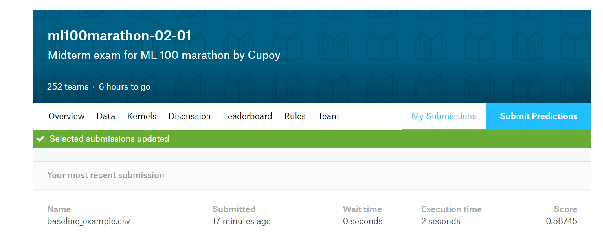

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

img = plt.imread(data_path +'051.png')
plt.figure(figsize=(10, 7))
plt.imshow(img)
plt.axis("off")
plt.show()